# 1. Data Analysis

In [1]:
import pandas as pd

# Load the data
train_data = pd.read_csv('Groceries data train.csv')
test_data = pd.read_csv('Groceries data test.csv')

# Print the first few rows of the train data
print(train_data.head())

# Print the first few rows of the test data
print(test_data.head())


   Member_number        Date  itemDescription  year  month  day  day_of_week
0           3021  30/01/2015      frankfurter  2015      1   30            4
1           1292  24/10/2015             pork  2015     10   24            5
2           4206   4/04/2014  root vegetables  2014      4    4            4
3           4369  25/08/2015           onions  2015      8   25            1
4           1522   1/07/2014          waffles  2014      7    1            1
   Member_number        Date itemDescription  year  month  day  day_of_week
0           3481   8/03/2015           candy  2015      3    8            6
1           1254  19/04/2015      white wine  2015      4   19            6
2           2835  28/01/2014   domestic eggs  2014      1   28            1
3           2854   2/08/2015          coffee  2015      8    2            6
4           4637  12/08/2014   bottled water  2014      8   12            1


In [2]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11765 entries, 0 to 11764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    11765 non-null  int64 
 1   Date             11765 non-null  object
 2   itemDescription  11765 non-null  object
 3   year             11765 non-null  int64 
 4   month            11765 non-null  int64 
 5   day      

In [3]:
# Check for missing values
print("Missing values in train data: ", train_data.isnull().sum())
print("Missing values in test data: ", test_data.isnull().sum())

Missing values in train data:  Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64
Missing values in test data:  Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64


No missing data

In [4]:
# Check unique values
print("Train data unique values:")
for column in train_data.columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")
    
print("\nTest data unique values:")
for column in test_data.columns:
    unique_values =test_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Train data unique values:
Column 'Member_number' has 3872 unique values.
Column 'Date' has 728 unique values.
Column 'itemDescription' has 167 unique values.
Column 'year' has 2 unique values.
Column 'month' has 12 unique values.
Column 'day' has 31 unique values.
Column 'day_of_week' has 7 unique values.

Test data unique values:
Column 'Member_number' has 3566 unique values.
Column 'Date' has 728 unique values.
Column 'itemDescription' has 162 unique values.
Column 'year' has 2 unique values.
Column 'month' has 12 unique values.
Column 'day' has 31 unique values.
Column 'day_of_week' has 7 unique values.


The train data seems to have more members and items containing than test data

In [5]:
# Check if there is new product or new member appearing in test data
# New items in test set
new_items = set(test_data['itemDescription']).difference(train_data['itemDescription'])
print("New items in test data: ", new_items)

# New members in test set
new_members = set(test_data['Member_number']).difference(train_data['Member_number'])
print("New members in test data: ", new_members)


New items in test data:  set()
New members in test data:  {2304, 2826, 3858, 1555, 1944, 3994, 2844, 3742, 1695, 1568, 4639, 3362, 4904, 4905, 1963, 1096, 1745, 4307, 1626, 4447, 1250, 1255, 2668, 4590, 2417, 4472}


No new items in test data, but there are new members appearing in test data.
This scenario could pose some challenges for a collaborative filtering approach, as it relies on past user behavior to make recommendations. This is often referred to as the "cold start" problem in recommendation systems. In such cases, a content-based or hybrid recommendation system might be a better fit, as they can handle new users by looking at the item features or by providing generic recommendations.

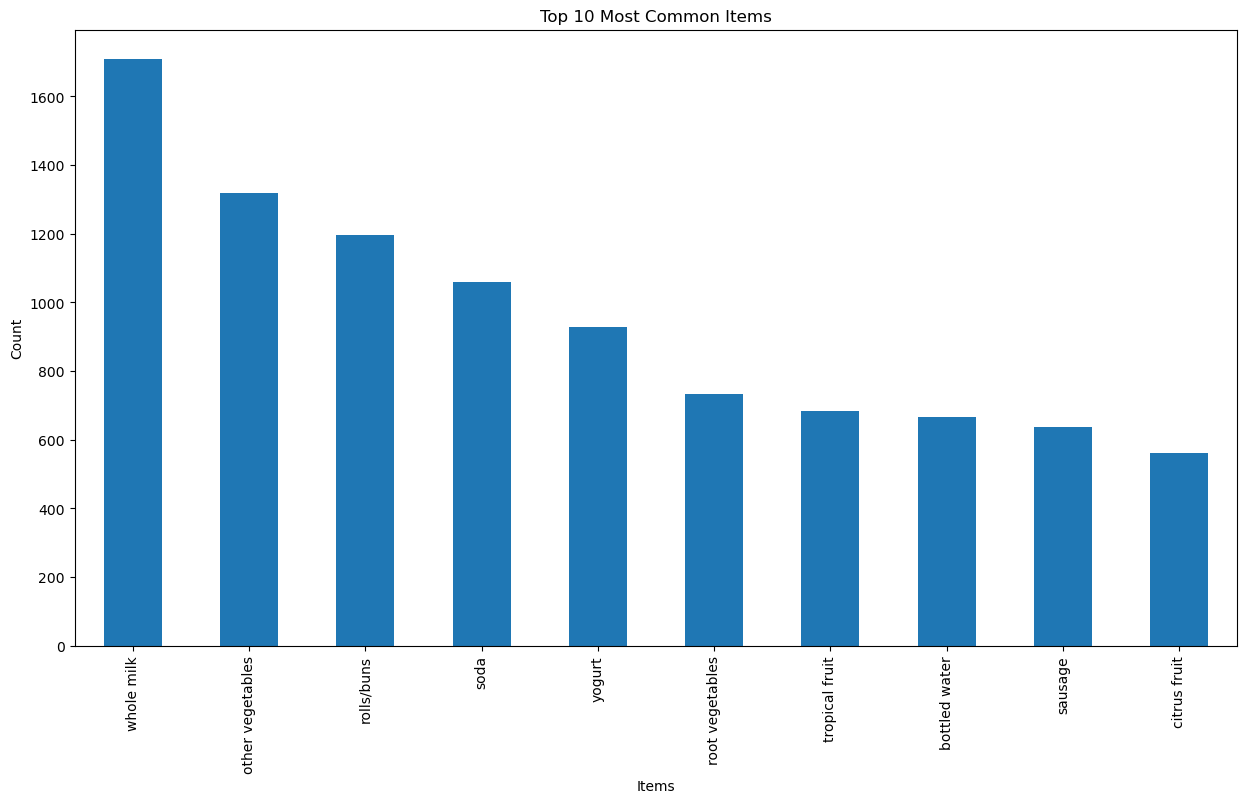

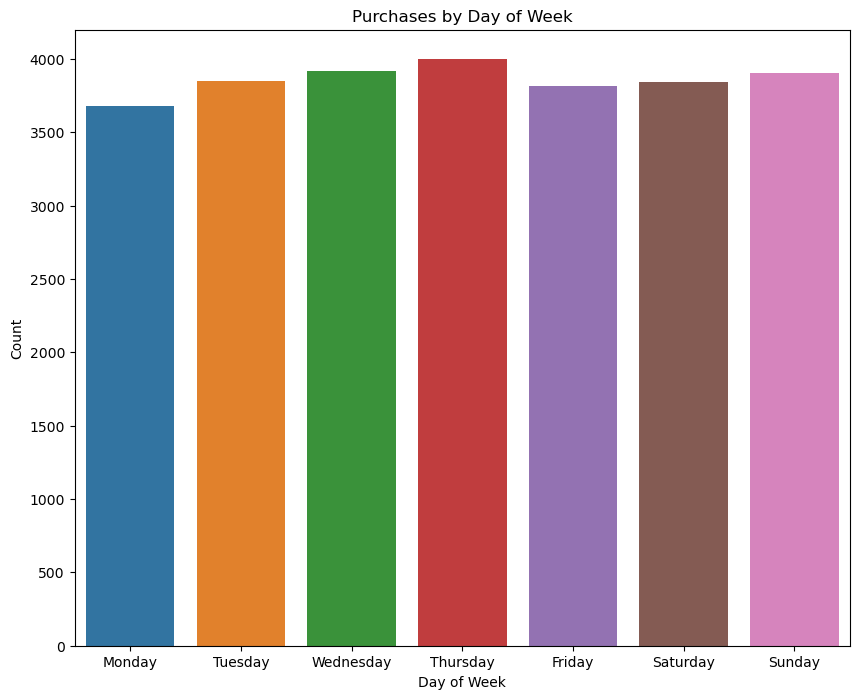

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Most common items
plt.figure(figsize=(15,8))
train_data['itemDescription'].value_counts()[:10].plot(kind='bar')
plt.title('Top 10 Most Common Items')
plt.xlabel('Items')
plt.ylabel('Count')
plt.show()

# Purchases by day of week
plt.figure(figsize=(10,8))
sns.countplot(x='day_of_week', data=train_data)
plt.title('Purchases by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


The top most popular items could be used for recommending for new users where we don't have historical data
The distribution of sales across the week, even though not significantly different, could be used to create time-based features. For instance, if a specific user tends to buy more frequently on a particular day of the week, this could be a valuable feature.

# 2. Recommendations and Evaluations

## 2.1 Collaborative Filtering Recommendation 

### 2.1.1 Recommendation Based on Item Similarity

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

# Load the training data
train_data = pd.read_csv('Groceries data train.csv')

# Create a pivot table with members as rows, items as columns and purchase as values
pivot_table = train_data.pivot_table(index='Member_number', columns='itemDescription', aggfunc='size', fill_value=0)

# Convert the pivot table to a sparse matrix for more efficient calculations
sparse_matrix = sparse.csr_matrix(pivot_table.values)

# Calculate the cosine similarity matrix
item_similarity = cosine_similarity(sparse_matrix.T)

# Create a dataframe for the similarity matrix
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table.columns, columns=pivot_table.columns)

# Function to recommend top k items for a user
def recommend_on_item_similarity(user, k=10):
    if user in pivot_table.index:
        user_items = pivot_table.loc[user]
        not_purchased = user_items[user_items == 0].index
        item_scores = item_similarity_df.loc[not_purchased].sum(axis=1)
        top_items_scores = item_scores.sort_values(ascending=False)[:k]
    else:  # user not in training data
        top_items_scores = pivot_table.sum().sort_values(ascending=False)[:k]
    
    # Return items and scores separately
    items = list(top_items_scores.index)
    scores = list(top_items_scores.values)
    return items, scores

# Test the function with a user
test_user = train_data['Member_number'].iloc[0]  # getting the Member_number of the first user in the dataset
print(recommend_on_item_similarity(test_user, 5))  # getting the top 5 recommendations for this user


(['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt'], [17.73357905597738, 15.886567295700388, 15.467029281002908, 14.648593232747096, 13.58992396101524])


The scores are the aggregate similarity scores of each item to the items the user has bought

### 2.1.2 Recommendation based on user similarity

In [8]:
# Calculate the cosine similarity matrix
user_similarity = cosine_similarity(sparse_matrix)

# Create a dataframe for the similarity matrix
user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table.index, columns=pivot_table.index)

# Function to recommend top k items for a user
def recommend_on_user_similarity(user, k=10):
    if user in pivot_table.index:
        user_similarities = user_similarity_df[user].sort_values(ascending=False)
        similar_users = user_similarities.index[1:k+1].tolist()  # Exclude the user themself

        recommended_items = []
        scores = []
        for similar_user in similar_users:
            similar_user_items = set(pivot_table.loc[similar_user][pivot_table.loc[similar_user] > 0].index)
            recommended_items.extend(similar_user_items)
            scores.extend([user_similarities[similar_user]]*len(similar_user_items))

        # If there are not enough items to recommend, recommend the most popular items
        if len(recommended_items) < k:
            popular_items = pivot_table.sum().sort_values(ascending=False)[:k].index
            popular_scores = pivot_table.sum().sort_values(ascending=False)[:k].values
            recommended_items.extend(popular_items[:k - len(recommended_items)])
            scores.extend(popular_scores[:k - len(recommended_items)])
    else:  # user not in training data
        recommended_items = list(pivot_table.sum().sort_values(ascending=False)[:k].index)
        scores = list(pivot_table.sum().sort_values(ascending=False)[:k].values)

    return recommended_items[:k], scores[:k]


# Test the function with a user
test_user = train_data['Member_number'].iloc[0]  # getting the Member_number of the first user in the dataset
print(recommend_on_user_similarity(test_user, 5))  # getting the top 5 recommendations for this user


(['spread cheese', 'bottled water', 'brown bread', 'frankfurter', 'onions'], [0.5345224838248487, 0.5345224838248487, 0.5345224838248487, 0.5345224838248487, 0.5345224838248487])


### 2.1.3 Evaluation of Collaborative Filtering 

In [9]:
# define a function to calculate the precision at k
def precision_at_k(test_data, recommend_function, k):
    hits = 0
    total = 0
    for user in test_data['Member_number'].unique():
        actual_items = set(test_data[test_data['Member_number'] == user]['itemDescription'])
        recommended_items, _ = recommend_function(user, k)  # Ignore scores
        hits += len(actual_items & set(recommended_items))
        total += k
    return hits / total

# define a function to calculate recall at k
def recall_at_k(test_data, recommend_function, k):
    hits = 0
    total = 0
    for user in test_data['Member_number'].unique():
        actual_items = set(test_data[test_data['Member_number'] == user]['itemDescription'])
        recommended_items, _ = recommend_function(user, k)  # Ignore scores
        hits += len(actual_items & set(recommended_items))
        total += len(actual_items)
    return hits / total

# Coverage
def coverage(test_data, recommend_function, k):
    recommended_items = set()
    for user in test_data['Member_number'].unique():
        items, _ = recommend_function(user, k)  # Ignore scores
        recommended_items.update(items)
    return len(recommended_items) / len(all_items)

# Define all_items as the set of all unique items in the dataset
all_items = set(train_data['itemDescription'])

In [10]:
# Load the test data
test_data = pd.read_csv('Groceries data test.csv')

# Initialize the list to hold the metrics data
metrics_data = []

# Evaluate the item-based recommendation function
print('Item-based recommendation:')
precision = precision_at_k(test_data, recommend_on_item_similarity, 10)
recall = recall_at_k(test_data, recommend_on_item_similarity, 10)
coverage_val = coverage(test_data, recommend_on_item_similarity, 10)

print('Precision@10:', precision)
print('Recall@10:', recall)
print('Coverage@10:', coverage_val)

# Add to the metrics data
metrics_data.append(('CF_Item_Based_test', {'Precision@10': precision, 'Recall@10': recall, 'Coverage@10': coverage_val}))

# Evaluate the user-based recommendation function
print('\nUser-based recommendation on test data:')
precision = precision_at_k(test_data, recommend_on_user_similarity, 10)
recall = recall_at_k(test_data, recommend_on_user_similarity, 10)
coverage_val = coverage(test_data, recommend_on_user_similarity, 10)

print('Precision@10:', precision)
print('Recall@10:', recall)
print('Coverage@10:', coverage_val)

# Add to the metrics data
metrics_data.append(('CF_User_Based_test', {'Precision@10': precision, 'Recall@10': recall, 'Coverage@10': coverage_val}))

# At the end, convert the list to DataFrame and save to CSV
df_metrics = pd.DataFrame.from_records(metrics_data, columns=['method', 'metrics'])
df_metrics = pd.concat([df_metrics['method'], df_metrics['metrics'].apply(pd.Series)], axis=1)
df_metrics.to_csv('metrics.csv', index=False)


Item-based recommendation:
Precision@10: 0.09694335389792484
Recall@10: 0.30356515630488234
Coverage@10: 0.12574850299401197

User-based recommendation on test data:
Precision@10: 0.05036455412226584
Recall@10: 0.15770987003863715
Coverage@10: 0.9640718562874252


In [11]:
# Load the test data
train_data = pd.read_csv('Groceries data train.csv')

# Evaluate the item-based recommendation function
print('Item-based recommendation on train data:')
precision = precision_at_k(train_data, recommend_on_item_similarity, 10)
recall = recall_at_k(train_data, recommend_on_item_similarity, 10)
coverage_val = coverage(train_data, recommend_on_item_similarity, 10)

print('Precision@10:', precision)
print('Recall@10:', recall)
print('Coverage@10:', coverage_val)

# Add to the metrics data
metrics_data.append(('CF_Item_Based_train', {'Precision@10': precision, 'Recall@10': recall, 'Coverage@10': coverage_val}))

# Evaluate the user-based recommendation function
print('\nUser-based recommendation on train data:')
precision = precision_at_k(train_data, recommend_on_user_similarity, 10)
recall = recall_at_k(train_data, recommend_on_user_similarity, 10)
coverage_val = coverage(train_data, recommend_on_user_similarity, 10)

print('Precision@10:', precision)
print('Recall@10:', recall)
print('Coverage@10:', coverage_val)

# Add to the metrics data
metrics_data.append(('CF_User_Based_train', {'Precision@10': precision, 'Recall@10': recall, 'Coverage@10': coverage_val}))

# At the end, convert the list to DataFrame and save to CSV
df_metrics = pd.DataFrame.from_records(metrics_data, columns=['method', 'metrics'])
df_metrics = pd.concat([df_metrics['method'], df_metrics['metrics'].apply(pd.Series)], axis=1)
df_metrics.to_csv('metrics.csv', index=False)


Item-based recommendation on train data:
Precision@10: 0.0
Recall@10: 0.0
Coverage@10: 0.12574850299401197

User-based recommendation on train data:
Precision@10: 0.39803719008264465
Recall@10: 0.6162335065973611
Coverage@10: 0.9640718562874252


This suggests that while the item-based recommendation system has a higher precision and recall, indicating that it was more accurate at predicting which items users would purchase, the user-based recommendation system provided a greater diversity of recommendations, as indicated by the higher coverage.

## 2.2 Recommendation Directly Based on Patterns

### 2.2.1 Pattern Mining

In [12]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# load the train data
df = pd.read_csv('Groceries data train.csv')

# Group by member number, and merge all item descriptions purchased by one member together
shoppingLists = df.groupby(['Member_number'])['itemDescription'].apply(list)
print(shoppingLists)

# TransactionEncoder expects a list as input, convert Panda series form to list
shoppingLists = shoppingLists.values.tolist()

# encode df to pandas DataFrame
te = TransactionEncoder()
te_ary = te.fit(shoppingLists).transform(shoppingLists)
df_encode = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm to identify frequent patterns
# Adjust the value of min_support to obtain an appropriate quantity of frequent itemsets.
# In this grocery store scenario, we firstly identify approximately frequent itemsets as basesets.
frequent_itemsets= apriori(df_encode, min_support=0.02, use_colnames=True)
print(frequent_itemsets)

Member_number
1000    [sausage, sausage, misc. beverages, canned bee...
1001    [rolls/buns, frankfurter, soda, soda, whole mi...
1002    [frozen vegetables, sugar, whole milk, tropica...
1003    [root vegetables, dental care, rolls/buns, sau...
1004    [other vegetables, canned beer, cling film/bag...
                              ...                        
4996    [dessert, bottled water, salty snack, decalcif...
4997    [canned beer, tropical fruit, white wine, grapes]
4998                                   [rolls/buns, curd]
4999    [newspapers, kitchen towels, onions, napkins, ...
5000    [soda, other vegetables, onions, fruit/vegetab...
Name: itemDescription, Length: 3872, dtype: object
      support                                  itemsets
0    0.052686                                (UHT-milk)
1    0.022211                           (baking powder)
2    0.090134                                    (beef)
3    0.057335                                 (berries)
4    0.043905    

In [13]:
#now need to only reserve itemsets which quatity more than one
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# we generate different itemsets with different min_support and the least amount of item
frequent_itemsets_2 = frequent_itemsets[frequent_itemsets['length'] > 1]
frequent_itemsets_2.to_csv('min_support_0.02/frequent_itemsets_GTE2.csv', index=False)
frequent_itemsets_3 = frequent_itemsets[frequent_itemsets['length'] > 2]
frequent_itemsets_3.to_csv('min_support_0.02/frequent_itemsets_GTE3.csv', index=False)

print(frequent_itemsets_2)

      support                                  itemsets  length
75   0.020145              (UHT-milk, other vegetables)       2
76   0.022727                    (UHT-milk, whole milk)       2
77   0.027893                  (beef, other vegetables)       2
78   0.025826                        (rolls/buns, beef)       2
79   0.021694                              (beef, soda)       2
..        ...                                       ...     ...
268  0.023502         (rolls/buns, sausage, whole milk)       3
269  0.031250            (rolls/buns, whole milk, soda)       3
270  0.020919  (rolls/buns, whole milk, tropical fruit)       3
271  0.029442          (rolls/buns, whole milk, yogurt)       3
272  0.025826                (whole milk, yogurt, soda)       3

[198 rows x 3 columns]


In [14]:
# get different patterns based on different min support
frequent_itemsets= apriori(df_encode, min_support=0.03, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# we generate different itemsets with different min_support and the least amount of item
frequent_itemsets_2 = frequent_itemsets[frequent_itemsets['length'] > 1]
frequent_itemsets_2.to_csv('min_support_0.03/frequent_itemsets_GTE2.csv', index=False)
frequent_itemsets_3 = frequent_itemsets[frequent_itemsets['length'] > 2]
frequent_itemsets_3.to_csv('min_support_0.03/frequent_itemsets_GTE3.csv', index=False)

frequent_itemsets= apriori(df_encode, min_support=0.04, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# we generate different itemsets with different min_support and the least amount of item
frequent_itemsets_2 = frequent_itemsets[frequent_itemsets['length'] > 1]
frequent_itemsets_2.to_csv('min_support_0.04/frequent_itemsets_GTE2.csv', index=False)
frequent_itemsets_3 = frequent_itemsets[frequent_itemsets['length'] > 2]
frequent_itemsets_3.to_csv('min_support_0.04/frequent_itemsets_GTE3.csv', index=False)

### 2.2.2 Direct recommend based on patterns

In [15]:
import pandas as pd

# Load the data
df_gte2_002 = pd.read_csv('./min_support_0.02/frequent_itemsets_GTE2.csv')
df_gte3_002 = pd.read_csv('./min_support_0.02/frequent_itemsets_GTE3.csv')

# See the most frequent bought itesmset
print("Top 10 frequent 2-itemsets:")
print(df_gte2_002.nlargest(10, 'support'))

print("\nTop 10 frequent 3-itemsets:")
print(df_gte3_002.nlargest(10, 'support'))

Top 10 frequent 2-itemsets:
      support                                       itemsets  length
124  0.112345  frozenset({'whole milk', 'other vegetables'})       2
151  0.106147        frozenset({'rolls/buns', 'whole milk'})       2
171  0.090393              frozenset({'whole milk', 'soda'})       2
180  0.087293            frozenset({'whole milk', 'yogurt'})       2
116  0.080837  frozenset({'rolls/buns', 'other vegetables'})       2
120  0.072056        frozenset({'other vegetables', 'soda'})       2
147  0.069473              frozenset({'rolls/buns', 'soda'})       2
30   0.068698     frozenset({'bottled water', 'whole milk'})       2
125  0.066116      frozenset({'yogurt', 'other vegetables'})       2
152  0.063533            frozenset({'rolls/buns', 'yogurt'})       2

Top 10 frequent 3-itemsets:
     support                                           itemsets  length
5   0.037448  frozenset({'rolls/buns', 'whole milk', 'other ...       3
10  0.031767  frozenset({'other vegetabl

In [16]:
# read all the pattern files
df_gte2_003 = pd.read_csv('./min_support_0.03/frequent_itemsets_GTE2.csv')
df_gte3_003 = pd.read_csv('./min_support_0.03/frequent_itemsets_GTE3.csv')
df_gte2_004 = pd.read_csv('./min_support_0.04/frequent_itemsets_GTE2.csv')
df_gte3_004 = pd.read_csv('./min_support_0.04/frequent_itemsets_GTE3.csv')

In [17]:
# generate recommend based on the patterns and history record
def recommend_items(member_number, df_gte2, df_gte3, transaction_data, k):
    # Get the user's transactions
    member_transactions = transaction_data[transaction_data['Member_number'] == member_number]
    
    # Get the items in the user's last 5 transactions
    last_items = member_transactions.tail(5)['itemDescription'].unique()
    
    # Find frequent itemsets (both 2-itemsets and 3-itemsets) that contain these items
    candidate_itemsets_2 = df_gte2[df_gte2['itemsets'].apply(lambda x: any(item in eval(x) for item in last_items))]
    candidate_itemsets_3 = df_gte3[df_gte3['itemsets'].apply(lambda x: any(item in eval(x) for item in last_items))]

    # Combine the itemsets and sort by support
    candidate_itemsets = pd.concat([candidate_itemsets_2, candidate_itemsets_3])
    recommended_itemsets = candidate_itemsets.sort_values(by='support', ascending=False)
    
    # Get the items in these itemsets, excluding items the user has just bought
    recommended_items = {}
    for _, row in recommended_itemsets.iterrows():
        items = eval(row['itemsets'])
        for item in items:
            if item not in last_items:
                if item in recommended_items:
                    recommended_items[item] = max(recommended_items[item], row['support'])
                else:
                    recommended_items[item] = row['support']

    # Return the top k recommended items and their scores
    sorted_items = sorted(recommended_items.items(), key=lambda item: item[1], reverse=True)
    return [item[0] for item in sorted_items[:k]], [item[1] for item in sorted_items[:k]]

# Load the transaction data
transaction_data = pd.read_csv('Groceries data train.csv')

# Test the function
member_number = 3021  # replace with actual member number
recommendations = recommend_items(member_number, df_gte2_002, df_gte3_002, transaction_data,10)
print(f"Recommended items for member {member_number}: {recommendations}")


Recommended items for member 3021: (['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt', 'tropical fruit', 'sausage', 'root vegetables', 'pastry', 'pip fruit'], [0.068698347107438, 0.0547520661157024, 0.0444214876033057, 0.043646694214876, 0.0356404958677685, 0.0307334710743801, 0.0286673553719008, 0.0276342975206611, 0.0237603305785123, 0.0232438016528925])


### 2.2.3 Evaluation

In [18]:
# define helper functions to calculate the precision at k
def precision_at_k_pattern(test_data, recommend_function, df_gte2, df_gte3, k):
    hits = 0
    total = 0
    for user in test_data['Member_number'].unique():
        actual_items = set(test_data[test_data['Member_number'] == user]['itemDescription'])
        recommended_items = set(recommend_function(user, df_gte2, df_gte3, train_data, k))
        hits += len(actual_items & recommended_items)
        total += k
    return hits / total

# define helper functions to calculate the recall at k
def recall_at_k_pattern(test_data, recommend_function, df_gte2, df_gte3, k):
    hits = 0
    total = 0
    for user in test_data['Member_number'].unique():
        actual_items = set(test_data[test_data['Member_number'] == user]['itemDescription'])
        recommended_items = set(recommend_function(user, df_gte2, df_gte3, train_data, k))
        hits += len(actual_items & recommended_items)
        total += len(actual_items)
    return hits / total

# define helper functions to calculate the coverage
def coverage_pattern(test_data, recommend_function, df_gte2, df_gte3, k):
    recommended_items = set()
    for user in test_data['Member_number'].unique():
        recommended_items.update(recommend_function(user, df_gte2, df_gte3, train_data, k))
    return len(recommended_items) / len(all_items)


In [90]:
# Load the test data
test_data = pd.read_csv('Groceries data test.csv')

# Define the list of frequent itemsets
frequent_itemsets = [(df_gte2_002, df_gte3_002), (df_gte2_003, df_gte3_003), (df_gte2_004, df_gte3_004)]

# Define a function to calculate the metrics for a given set of frequent itemsets
def calculate_pattern_metrics(test_data, df_gte2, df_gte3):
    # Define a function to recommend items based on the frequent itemsets
    def recommend_pattern(member_number, k):
        return recommend_items(member_number, df_gte2, df_gte3, transaction_data, k)

    # Calculate the metrics
    precision = precision_at_k(test_data, recommend_pattern, 10)
    recall = recall_at_k(test_data, recommend_pattern, 10)
    cov = coverage(test_data, recommend_pattern, 10)

    # Return the metrics
    return {'Precision@10': precision, 'Recall@10': recall, 'Coverage@10': cov}

In [91]:
# Calculate the metrics for each set of frequent itemsets
for i, (df_gte2, df_gte3) in enumerate(frequent_itemsets):
    print(f'\nPattern mining recommendation on test data (min_support={0.02 + i * 0.01}):')
    metrics = calculate_pattern_metrics(test_data, df_gte2, df_gte3)
    print('Precision@10:', metrics['Precision@10'])
    print('Recall@10:', metrics['Recall@10'])
    print('Coverage@10:', metrics['Coverage@10'])
    # Add to the metrics data
    metrics_data.append((f'Pattern_Mining_{0.02 + i * 0.01}_test', metrics))

# At the end, convert the list to DataFrame and save to CSV
df_metrics = pd.DataFrame.from_records(metrics_data, columns=['method', 'metrics'])
df_metrics = pd.concat([df_metrics['method'], df_metrics['metrics'].apply(pd.Series)], axis=1)
df_metrics.to_csv('metrics.csv', index=False)


Pattern mining recommendation (min_support=0.02):
Precision@10: 0.09727986539540101
Recall@10: 0.3046188970846505
Coverage@10: 0.10778443113772455

Pattern mining recommendation (min_support=0.03):
Precision@10: 0.08634324172742569
Recall@10: 0.27037232174218473
Coverage@10: 0.10179640718562874

Pattern mining recommendation (min_support=0.04):
Precision@10: 0.07470555243970836
Recall@10: 0.2339304531085353
Coverage@10: 0.09580838323353294


In [ ]:
# Load the train data
test_data = pd.read_csv('Groceries data train.csv')

# Calculate the metrics for each set of frequent itemsets
for i, (df_gte2, df_gte3) in enumerate(frequent_itemsets):
    print(f'\nPattern mining recommendation on test data (min_support={0.02 + i * 0.01}):')
    metrics = calculate_pattern_metrics(train_data, df_gte2, df_gte3)
    print('Precision@10:', metrics['Precision@10'])
    print('Recall@10:', metrics['Recall@10'])
    print('Coverage@10:', metrics['Coverage@10'])
    # Add to the metrics data
    metrics_data.append((f'Pattern_Mining_{0.02 + i * 0.01}_train', metrics))

# At the end, convert the list to DataFrame and save to CSV
df_metrics = pd.DataFrame.from_records(metrics_data, columns=['method', 'metrics'])
df_metrics = pd.concat([df_metrics['method'], df_metrics['metrics'].apply(pd.Series)], axis=1)
df_metrics.to_csv('metrics.csv', index=False)

From the results, it's apparent that as the minimum support increases, the precision, recall, and coverage decrease. This is expected because higher support values mean that we're considering more frequent itemsets for recommendations, which can reduce the chance of recommending items that the user is interested in. Also, higher support values can lead to fewer unique items in the recommendations, reducing the coverage.

## 2.3 Recommendation Based On Association Rules

### 2.3.1 Pattern Mining

In [92]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Read data
df = pd.read_csv('Groceries data train.csv')

# Group by member number, and merge all item descriptions purchased by one member together
shoppingLists = df.groupby(['Member_number'])['itemDescription'].apply(list)
shoppingLists = shoppingLists.values.tolist()

# encode df to pandas DataFrame
te = TransactionEncoder()
te_ary = te.fit(shoppingLists).transform(shoppingLists)
df_encode = pd.DataFrame(te_ary, columns=te.columns_)

# Get frequent itemsets with a minimum support of 0.02
frequent_itemsets = apriori(df_encode, min_support=0.02, use_colnames=True)


### 2.3.2 Association Rules generation

In [93]:
# get rules based on lift and write into csv file
rules_lift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.3)
print(rules_lift)
rules_lift.to_csv("rules_lift_1.3.csv", index=False)

           antecedents               consequents  antecedent support  \
0           (UHT-milk)        (other vegetables)            0.052686   
1   (other vegetables)                (UHT-milk)            0.284866   
2             (pastry)            (bottled beer)            0.130424   
3       (bottled beer)                  (pastry)            0.118285   
4       (bottled beer)               (pip fruit)            0.118285   
..                 ...                       ...                 ...   
73            (yogurt)  (rolls/buns, whole milk)            0.205837   
74      (soda, yogurt)              (whole milk)            0.056302   
75  (soda, whole milk)                  (yogurt)            0.090393   
76            (yogurt)        (soda, whole milk)            0.205837   
77        (whole milk)            (soda, yogurt)            0.347366   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.284866  0.020145    0.382353  1.342222 

In [94]:
# Generate rules based on support
rules_support=association_rules(frequent_itemsets, metric="support", min_threshold=0.04)
rules_support.to_csv("rule_support_0.04.csv", index=False)
print("Rules based on support(threshold 0.04)")
print(rules_support)

Rules based on support(threshold 0.04)
             antecedents           consequents  antecedent support  \
0         (bottled beer)          (whole milk)            0.118285   
1           (whole milk)        (bottled beer)            0.347366   
2        (bottled water)    (other vegetables)            0.159866   
3     (other vegetables)       (bottled water)            0.284866   
4        (bottled water)          (rolls/buns)            0.159866   
..                   ...                   ...                 ...   
79          (whole milk)      (tropical fruit)            0.347366   
80  (whipped/sour cream)          (whole milk)            0.113636   
81          (whole milk)  (whipped/sour cream)            0.347366   
82              (yogurt)          (whole milk)            0.205837   
83          (whole milk)              (yogurt)            0.347366   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.347366  0.051136    0.43

In [95]:
# Generate rules based on confidence
rules_confidence=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)
rules_confidence.to_csv("rule_confidence_0.35.csv", index=False)
print("Rules based on confidence(threshold 0.35)")
print(rules_confidence)

Rules based on confidence(threshold 0.35)
                     antecedents         consequents  antecedent support  \
0                     (UHT-milk)  (other vegetables)            0.052686   
1                     (UHT-milk)        (whole milk)            0.052686   
2                         (beef)        (whole milk)            0.090134   
3                      (berries)        (whole milk)            0.057335   
4                 (bottled beer)        (whole milk)            0.118285   
..                           ...                 ...                 ...   
58         (sausage, rolls/buns)        (whole milk)            0.046746   
59            (soda, rolls/buns)        (whole milk)            0.069473   
60  (rolls/buns, tropical fruit)        (whole milk)            0.047004   
61          (rolls/buns, yogurt)        (whole milk)            0.063533   
62                (soda, yogurt)        (whole milk)            0.056302   

    consequent support   support  confidence 

### 2.3.3 Recommendation Implementation

In [96]:
def recommend_ar_lift(member_number, top_n=10):
     # Check if member_number exists in the data
    if member_number not in df['Member_number'].unique():
        # If not, return the top-N most common items
        most_common_items = df['itemDescription'].value_counts().index[:top_n].tolist()
        return most_common_items, [None]*top_n
    
    # Filter the rules based on the items bought by the member
    member_items = set(df[df['Member_number'] == member_number]['itemDescription'].unique())
    rules_lift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.3)
    rules_lift = rules_lift[rules_lift['antecedents'].apply(lambda x: any(item in set(x) for item in member_items))]
    
    # Sort the rules by lift value
    rules_lift.sort_values('lift', ascending = False, inplace = True)
    
    # Get the top_n items with highest lift value
    recommendations = rules_lift['consequents'].head(top_n)
    
    # Also get their corresponding lift values
    scores = rules_lift['lift'].head(top_n)
    
    # Convert frozensets in 'recommendations' to list of strings
    recommendations = [list(x)[0] for x in recommendations]
    
    return recommendations, scores


def recommend_ar_support(member_number, top_n=10):
     # Check if member_number exists in the data
    if member_number not in df['Member_number'].unique():
        # If not, return the top-N most common items
        most_common_items = df['itemDescription'].value_counts().index[:top_n].tolist()
        return most_common_items, [None]*top_n
    # Filter the rules based on the items bought by the member
    member_items = set(df[df['Member_number'] == member_number]['itemDescription'].unique())
    rules_support=association_rules(frequent_itemsets, metric="support", min_threshold=0.04)
    rules_support = rules_support[rules_support['antecedents'].apply(lambda x: any(item in set(x) for item in member_items))]
    
    # Sort the rules by support value
    rules_support.sort_values('support', ascending = False, inplace = True)
    
    # Get the top_n items with highest support value
    recommendations = rules_support['consequents'].head(top_n)
    
    # Also get their corresponding support values
    scores = rules_support['support'].head(top_n)
    
    # Convert frozensets in 'recommendations' to list of strings
    recommendations = [list(x)[0] for x in recommendations]
    
    return recommendations, scores

def recommend_ar_confidence(member_number, top_n=10):
     # Check if member_number exists in the data
    if member_number not in df['Member_number'].unique():
        # If not, return the top-N most common items
        most_common_items = df['itemDescription'].value_counts().index[:top_n].tolist()
        return most_common_items, [None]*top_n
    
    # Filter the rules based on the items bought by the member
    member_items = set(df[df['Member_number'] == member_number]['itemDescription'].unique())
    rules_confidence=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)
    rules_confidence = rules_confidence[rules_confidence['antecedents'].apply(lambda x: any(item in set(x) for item in member_items))]
    
    # Sort the rules by confidence value
    rules_confidence.sort_values('confidence', ascending = False, inplace = True)
    
    # Get the top_n items with highest confidence value
    recommendations = rules_confidence['consequents'].head(top_n)
    
    # Also get their corresponding confidence values
    scores = rules_confidence['confidence'].head(top_n)
    
    # Convert frozensets in 'recommendations' to list of strings
    recommendations = [list(x)[0] for x in recommendations]
    
    return recommendations, scores


In [97]:
# read the test data
test_data = pd.read_csv('Groceries data test.csv')

# Select a member number from test data for demonstration
member_number = test_data.iloc[0]['Member_number']

# test the three methods
print("Recommendations based on Lift:")
print(recommend_ar_lift(member_number))

print("Recommendations based on Support:")
print(recommend_ar_support(member_number))

print("Recommendations based on Confidence:")
print(recommend_ar_confidence(member_number))

Recommendations based on Lift:
(['whole milk', 'bottled beer', 'bottled water', 'bottled beer', 'sausage', 'rolls/buns', 'whole milk', 'bottled water', 'sausage', 'sausage'], 34    1.557712
39    1.557712
41    1.538648
35    1.535351
63    1.493561
62    1.465179
40    1.452984
45    1.452984
65    1.447358
54    1.442172
Name: lift, dtype: float64)
Recommendations based on Support:
(['other vegetables', 'whole milk', 'rolls/buns', 'soda', 'whole milk', 'yogurt', 'whole milk', 'rolls/buns', 'other vegetables', 'soda'], 39    0.112345
38    0.112345
56    0.106147
75    0.090393
74    0.090393
83    0.087293
82    0.087293
26    0.080837
34    0.072056
35    0.072056
Name: support, dtype: float64)
Recommendations based on Confidence:
(['whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk', 'whole milk'], 42    0.541096
44    0.504717
54    0.480469
47    0.467456
61    0.463415
48    0.463259
62    0.458716
59    0.

### 2.3.4 Recommendation Evaluation

In [98]:
# prepare the test data
test_data = pd.read_csv('Groceries data test.csv')
test_shoppingLists = test_data.groupby(['Member_number'])['itemDescription'].apply(list)
test_members = test_data['Member_number'].unique()

# Define the evaluation function
def evaluate_method(recommend_func, k=10):
    hits = 0
    total_predicted = 0
    total_actual = 0
    all_recommended = set()

    for i, user in enumerate(test_shoppingLists):
        actual_items = set(user)
        member_number = test_members[i]
        recommended_items, _ = recommend_func(member_number, k)

        hits += len(set(recommended_items) & actual_items)
        total_predicted += len(recommended_items)
        total_actual += len(actual_items)
        all_recommended.update(recommended_items)

    precision = hits / total_predicted if total_predicted > 0 else 0
    recall = hits / total_actual if total_actual > 0 else 0
    coverage = len(all_recommended) / df['itemDescription'].nunique()

    return precision, recall, coverage


In [99]:
# Compute metrics for each method
metrics = pd.DataFrame(columns=['method', 'Precision@10', 'Recall@10', 'Coverage@10'])
methods = [recommend_ar_lift, recommend_ar_support, recommend_ar_confidence]
method_names = ['AR_Lift', 'AR_Support', 'AR_Confidence']

for i in range(3):
    precision, recall, coverage = evaluate_method(methods[i], k=10)
    metrics.loc[i] = [method_names[i], precision, recall, coverage]

print(metrics)

# Read existing metrics file
existing_metrics = pd.read_csv('metrics.csv')

# Append new metrics
all_metrics = pd.concat([existing_metrics, metrics])

# Save to csv
all_metrics.to_csv('metrics.csv', index=False)

          method  Precision@10  Recall@10  Coverage@10
0        AR_Lift      0.060601   0.160432     0.125749
1     AR_Support      0.089491   0.235687     0.071856
2  AR_Confidence      0.033113   0.087197     0.059880


Recommendation function based on support has the highest precision and recall, while the function based on lift has the highest coverage.

This implies that the function based on support is more likely to recommend relevant items to the user, but the function based on lift can recommend a wider variety of items.

## 2.4 Recommendation Combining Association Rules and Collaborative Filtering

### 2.4.1 Combining Association Rules(Support) and Collaborativ Filtering (Item Similarity) 

In [111]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def hybrid_item_ar_support(member_number, top_n=10):
    # Get recommendations from both methods
    cf_items, cf_scores = recommend_on_item_similarity(member_number, top_n)
    ar_items, ar_scores = recommend_ar_support(member_number, top_n)
    
    # Initialize a MinMaxScaler
    scaler = MinMaxScaler()
    
    # Reshape the scores to fit the scaler's expected input shape
    cf_scores = np.array(cf_scores).reshape(-1, 1)
    ar_scores = np.array(ar_scores).reshape(-1, 1)
    
    # Fit the scaler to the scores and transform them if scores are not empty
    cf_scores = scaler.fit_transform(cf_scores).flatten() if cf_scores.size > 0 else cf_scores
    ar_scores = scaler.fit_transform(ar_scores).flatten() if ar_scores.size > 0 else ar_scores
    
    # Initialize a dictionary to hold the combined scores
    combined_scores = {}
    
    # Add scores from collaborative filtering method
    for item, score in zip(cf_items, cf_scores):
        if score is not None:  # Exclude items recommended when user not in training data
            combined_scores[item] = score
            
    # Add scores from association rules method, or add to existing scores if already present
    for item, score in zip(ar_items, ar_scores):
        if score is not None:  # Exclude items recommended when user not in training data
            if item in combined_scores:
                combined_scores[item] += score
            else:
                combined_scores[item] = score
                
    # Sort items by their combined scores
    sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top_n items with highest combined scores
    recommendations = [item for item, score in sorted_items[:top_n]]
    scores = [score for item, score in sorted_items[:top_n]]
    
    return recommendations, scores


In [112]:
# read the test data
test_data = pd.read_csv('Groceries data test.csv')

# Select a member number from test data for demonstration
member_number = test_data.iloc[0]['Member_number']

# test the function
hybrid_item_ar_support(member_number)

(['rolls/buns',
  'whole milk',
  'other vegetables',
  'soda',
  'bottled water',
  'root vegetables',
  'yogurt',
  'tropical fruit',
  'sausage',
  'shopping bags'],
 [2.0641025641025643,
  1.8333333333333335,
  1.0,
  0.4551282051282053,
  0.41715819530434883,
  0.4106684036230379,
  0.3782051282051282,
  0.33538746466842007,
  0.3266886994224918,
  0.07116409506938348])

### 2.4.2 Combining Association Rules(Support) and Collaborativ Filtering (Item Similarity) 

In [113]:
# define a hybrid function to combine user similarity recommendation and association rules recommendation
def hybrid_user_ar_support(member_number, top_n=10):
    # Get recommendations from both methods
    cf_items, cf_scores = recommend_on_user_similarity(member_number, top_n)
    ar_items, ar_scores = recommend_ar_support(member_number, top_n)
    
    # Initialize a MinMaxScaler
    scaler = MinMaxScaler()
    
    # Reshape the scores to fit the scaler's expected input shape
    cf_scores = np.array(cf_scores).reshape(-1, 1)
    ar_scores = np.array(ar_scores).reshape(-1, 1)
    
    # Fit the scaler to the scores and transform them if scores are not empty
    cf_scores = scaler.fit_transform(cf_scores).flatten() if cf_scores.size > 0 else cf_scores
    ar_scores = scaler.fit_transform(ar_scores).flatten() if ar_scores.size > 0 else ar_scores
    
    # Initialize a dictionary to hold the combined scores
    combined_scores = {}
    
    # Add scores from collaborative filtering method
    for item, score in zip(cf_items, cf_scores):
        if score is not None:  # Exclude items recommended when user not in training data
            combined_scores[item] = score
            
    # Add scores from association rules method, or add to existing scores if already present
    for item, score in zip(ar_items, ar_scores):
        if score is not None:  # Exclude items recommended when user not in training data
            if item in combined_scores:
                combined_scores[item] += score
            else:
                combined_scores[item] = score
                
    # Sort items by their combined scores
    sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top_n items with highest combined scores
    recommendations = [item for item, score in sorted_items[:top_n]]
    scores = [score for item, score in sorted_items[:top_n]]
    
    return recommendations, scores


In [114]:
# read the test data
test_data = pd.read_csv('Groceries data test.csv')

# Select a member number from test data for demonstration
member_number = test_data.iloc[0]['Member_number']

# test the function
hybrid_user_ar_support(member_number)

(['other vegetables',
  'whole milk',
  'rolls/buns',
  'soda',
  'yogurt',
  'sausage',
  'butter',
  'beef',
  'frozen fish'],
 [2.0,
  1.8333333333333335,
  1.0641025641025643,
  0.4551282051282053,
  0.3782051282051282,
  0.0,
  0.0,
  0.0,
  0.0])

### 2.4.3 Evalutate The Two Hybrid Functions

In [115]:
# define helper functions
def calculate_precision_recall_at_k(test_data, recommend_function, k=10):
    precisions = []
    recalls = []
    
    for user in test_data['Member_number'].unique():
        # Get the items the user has interacted with in the test data
        test_items = set(test_data[test_data['Member_number'] == user]['itemDescription'].tolist())
        
        # Get the top-k items recommended by the function
        recommended_items, _ = recommend_function(user, k)
        recommended_items = set(recommended_items)
        
        # Calculate precision and recall
        tp = len(test_items & recommended_items)
        precision = tp / len(recommended_items)
        recall = tp / len(test_items)
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Calculate average precision and recall
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    
    return avg_precision, avg_recall

def calculate_coverage_at_k(test_data, recommend_function, k=10):
    unique_items = set(test_data['itemDescription'].unique())
    recommended_items = set()
    
    for user in test_data['Member_number'].unique():
        items, _ = recommend_function(user, k)
        recommended_items.update(items)
    
    coverage = len(recommended_items) / len(unique_items)
    return coverage


In [116]:
# prepare the test data
test_data = pd.read_csv('Groceries data test.csv')
metrics = pd.DataFrame(columns=['method', 'Precision@10', 'Recall@10', 'Coverage@10'])
methods = [hybrid_item_ar_support, hybrid_user_ar_support]
method_names = ['ItemCF_AR', 'UserCF_AR']

for i in range(2):
    precision, recall = calculate_precision_recall_at_k(test_data, methods[i], k=10)
    coverage=calculate_coverage_at_k(test_data, methods[i],k=10)
    metrics.loc[i] = [method_names[i], precision, recall, coverage]

print(metrics)

# Read existing metrics file
existing_metrics = pd.read_csv('metrics.csv')

# Append new metrics
all_metrics = pd.concat([existing_metrics, metrics])

# Save to csv
all_metrics.to_csv('metrics.csv', index=False)

C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data

C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data

C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data

C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\10168\anaconda3\lib\site-packages\sklearn\preprocessing\_data

      method  Precision@10  Recall@10  Coverage@10
0  ItemCF_AR      0.107459   0.346098     0.111111
1  UserCF_AR      0.093570   0.283562     0.981481


# 3 Runtime Analysis

## 3.1 Runtime Of Pattern Mining

In [8]:
import pandas as pd
import time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def run_pattern_mining(df):
    # Group by member number, and merge all item descriptions purchased by one member together
    shoppingLists = df.groupby(['Member_number'])['itemDescription'].apply(list)
    shoppingLists = shoppingLists.values.tolist()

    # encode df to pandas DataFrame
    te = TransactionEncoder()
    te_ary = te.fit(shoppingLists).transform(shoppingLists)
    df_encode = pd.DataFrame(te_ary, columns=te.columns_)

    # Get frequent itemsets with a minimum support of 0.02
    frequent_itemsets = apriori(df_encode, min_support=0.02, use_colnames=True)
    
    return frequent_itemsets

# Datasets sizes for runtime analysis
dataset_sizes = [100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]

# Load the initial dataset
df = pd.read_csv('Groceries data train.csv')

# For each size, create a smaller dataset and save it to a CSV file
for size in dataset_sizes:
    df_sample = df.sample(n=size, random_state=1)
    df_sample.to_csv(f'Groceries data train_{size}.csv', index=False)

# Dataframe to store the results
results_df = pd.DataFrame(columns=["dataset_size", "runtime"])

for size in dataset_sizes:
    # Load a dataset of the required size
    df = pd.read_csv(f'Groceries data train_{size}.csv')

    start_time = time.perf_counter()
    frequent_itemsets = run_pattern_mining(df)
    end_time = time.perf_counter()

    runtime = end_time - start_time
    print(f"Dataset size: {size}, Runtime: {runtime} seconds")

    # Append the results to the dataframe
    results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv("runtime_analysis_results.csv", index=False)


Dataset size: 100, Runtime: 0.004282200000034209 seconds
Dataset size: 500, Runtime: 0.009900099999981649 seconds
Dataset size: 1000, Runtime: 0.01628899999997202 seconds
Dataset size: 2000, Runtime: 0.027187800000035622 seconds
Dataset size: 5000, Runtime: 0.049530300000014904 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is

Dataset size: 10000, Runtime: 0.07972690000002558 seconds
Dataset size: 15000, Runtime: 0.096597700000018 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)


Dataset size: 20000, Runtime: 0.11134060000000545 seconds
Dataset size: 25000, Runtime: 0.13706010000004198 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2639329580.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)


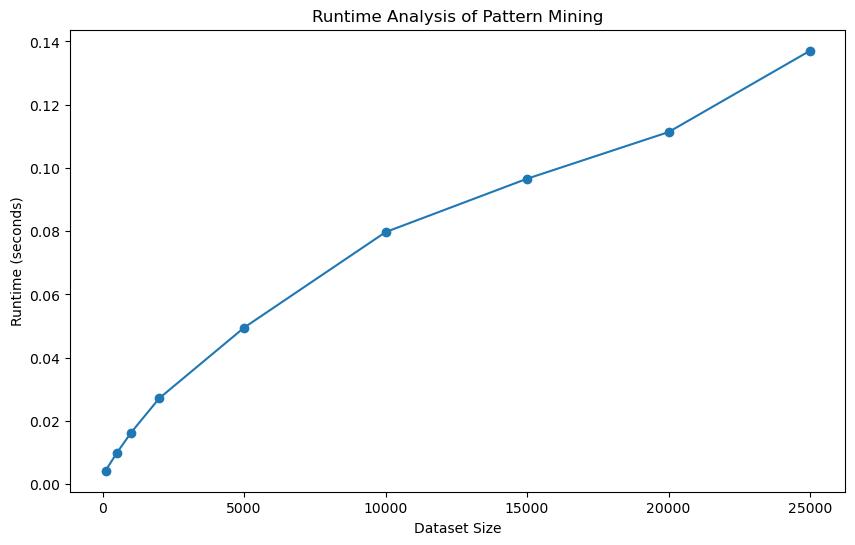

In [9]:
import matplotlib.pyplot as plt

# Load the runtime analysis results
results_df = pd.read_csv("runtime_analysis_results.csv")

# Create a plot
plt.figure(figsize=(10, 6))

# Plot dataset_size vs runtime
plt.plot(results_df["dataset_size"], results_df["runtime"], marker='o')

# Set the title and labels
plt.title('Runtime Analysis of Pattern Mining')
plt.xlabel('Dataset Size')
plt.ylabel('Runtime (seconds)')

# Show the plot
plt.show()


It's a roughly linear runtime plot.

In [10]:
# Predict the runtime of 1 million dataset
import numpy as np

# store the runtime data
runtime = pd.read_csv("runtime_analysis_results.csv")

# Fit a line to the data using numpy's polyfit function
coefficients = np.polyfit(runtime["dataset_size"], runtime["runtime"], 1)

# The coefficients represent the slope and intercept of the best fit line
slope = coefficients[0]
intercept = coefficients[1]

# Now we can use the line equation to predict the runtime for a dataset of size 1,000,000
predicted_runtime = slope * 1000000 + intercept
print(f"Predicted runtime for dataset of size 1,000,000: {predicted_runtime} seconds")


Predicted runtime for dataset of size 1,000,000: 5.170814166489873 seconds


## 3.2 Runtime of Similarity Calculation

In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

def run_item_based_similarity(df):
    # Create a pivot table with members as rows, items as columns and purchase as values
    pivot_table = df.pivot_table(index='Member_number', columns='itemDescription', aggfunc='size', fill_value=0)

    # Convert the pivot table to a sparse matrix for more efficient calculations
    sparse_matrix = sparse.csr_matrix(pivot_table.values)

    # Calculate the cosine similarity matrix
    start_time = time.perf_counter()
    item_similarity = cosine_similarity(sparse_matrix.T)
    end_time = time.perf_counter()

    # Return the runtime
    return end_time - start_time

# Datasets sizes for runtime analysis
dataset_sizes = [10000, 11000,12000,13000,14000,15000, 20000, 25000]

# load the train data
df = pd.read_csv('Groceries data train.csv')

# For each size, create a smaller dataset and save it to a CSV file
for size in dataset_sizes:
    df_sample = df.sample(n=size, random_state=1)
    df_sample.to_csv(f'Groceries data train_{size}.csv', index=False)

# Dataframe to store the results
results_df = pd.DataFrame(columns=["dataset_size", "runtime"])

for size in dataset_sizes:
    # Load a dataset of the required size
    df = pd.read_csv(f'Groceries data train_{size}.csv')

    runtime = run_item_based_similarity(df)
    print(f"Dataset size: {size}, Runtime: {runtime} seconds")

    # Append the results to the dataframe
    results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv("item_similarity_runtime_analysis_results.csv", index=False)


Dataset size: 10000, Runtime: 0.0011919000000091273 seconds
Dataset size: 11000, Runtime: 0.0011718999999743573 seconds
Dataset size: 12000, Runtime: 0.0012229999999817665 seconds
Dataset size: 13000, Runtime: 0.0012299999999925149 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is

Dataset size: 14000, Runtime: 0.0014040000000079544 seconds
Dataset size: 15000, Runtime: 0.0015319999999974243 seconds
Dataset size: 20000, Runtime: 0.0018291000000090207 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)
C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)


Dataset size: 25000, Runtime: 0.002501700000010487 seconds


C:\Users\10168\AppData\Local\Temp\ipykernel_11792\2261053919.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"dataset_size": size, "runtime": runtime}, ignore_index=True)


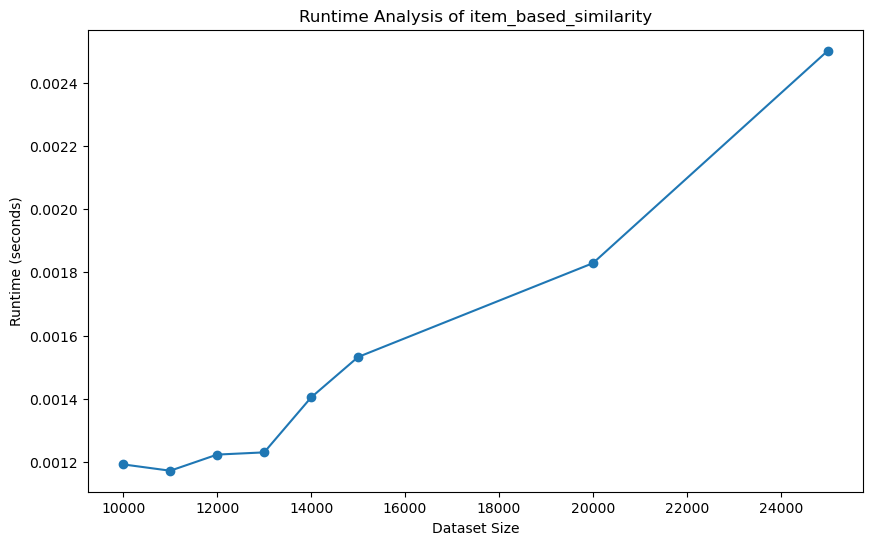

In [4]:
import matplotlib.pyplot as plt

# Load the runtime analysis results
results_df = pd.read_csv("item_similarity_runtime_analysis_results.csv")

# Create a plot
plt.figure(figsize=(10, 6))

# Plot dataset_size vs runtime
plt.plot(results_df["dataset_size"], results_df["runtime"], marker='o')

# Set the title and labels
plt.title('Runtime Analysis of item_based_similarity')
plt.xlabel('Dataset Size')
plt.ylabel('Runtime (seconds)')

# Show the plot
plt.show()

In [5]:
import numpy as np
import pandas as pd

# Load your CSV file
item_similarity_results = pd.read_csv('item_similarity_runtime_analysis_results.csv')

# Fit a polynomial of degree 2 (quadratic) to the data
coefficients = np.polyfit(item_similarity_results['dataset_size'], item_similarity_results['runtime'], 2)

# Use the fitted polynomial to predict the runtime for a dataset of size 1 million
predicted_runtime = np.polyval(coefficients, 1000000)

print(f"The estimated runtime for a dataset of size 1 million is {predicted_runtime} seconds.")


The estimated runtime for a dataset of size 1 million is 3.244422017122034 seconds.


Note that is runtime doesn't include the time of recommending but preparing the data for recommendation

# 4 Result Discussion

                method  Precision@10  Recall@10  Coverage@10
0        CF_Item_Based      0.096943   0.303565     0.125749
1        CF_User_Based      0.051038   0.159817     0.952096
2  Pattern_Mining_0.02      0.097280   0.304619     0.107784
3  Pattern_Mining_0.03      0.086343   0.270372     0.101796
4  Pattern_Mining_0.04      0.074706   0.233930     0.095808
5              AR_Lift      0.060601   0.160432     0.125749
6           AR_Support      0.089491   0.235687     0.071856
7        AR_Confidence      0.033113   0.087197     0.059880
8            ItemCF_AR      0.107459   0.346098     0.111111
9            UserCF_AR      0.093570   0.283562     0.981481


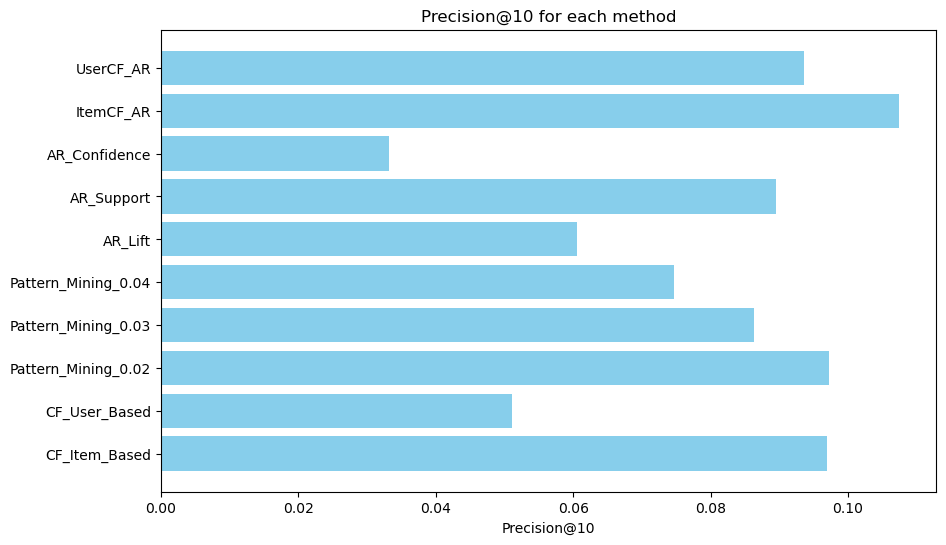

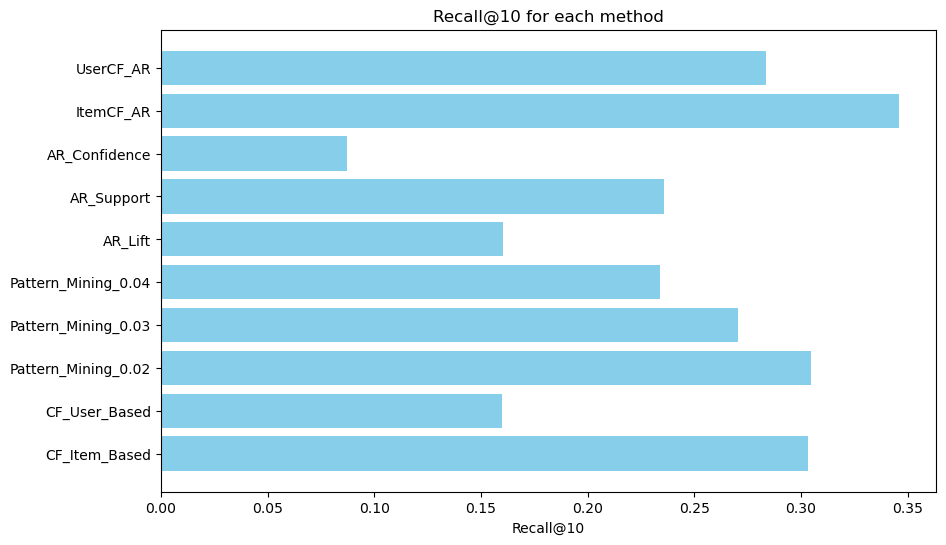

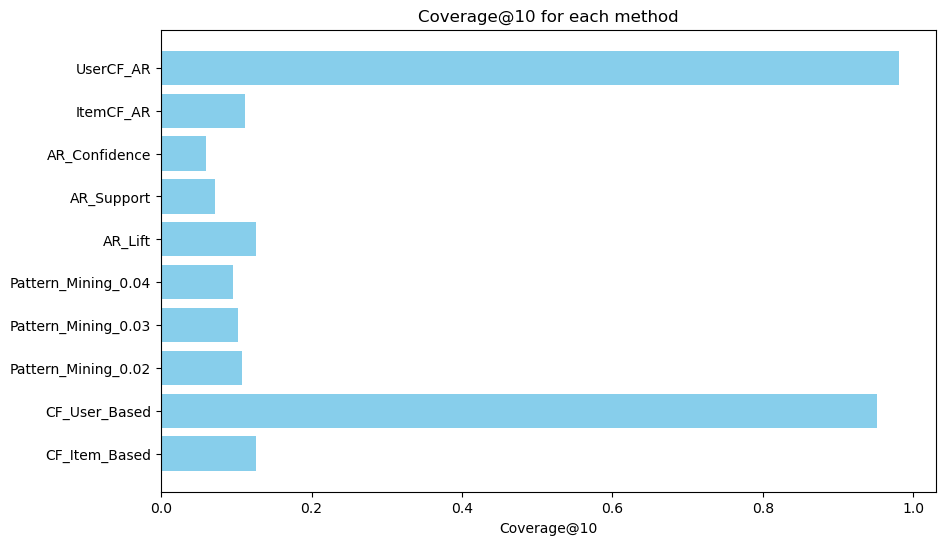

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('metrics.csv')

# Display the data
print(df)

# Plot Precision@10
plt.figure(figsize=(10, 6))
plt.barh(df['method'], df['Precision@10'], color='skyblue')
plt.xlabel('Precision@10')
plt.title('Precision@10 for each method')
plt.show()

# Plot Recall@10
plt.figure(figsize=(10, 6))
plt.barh(df['method'], df['Recall@10'], color='skyblue')
plt.xlabel('Recall@10')
plt.title('Recall@10 for each method')
plt.show()

# Plot Coverage@10
plt.figure(figsize=(10, 6))
plt.barh(df['method'], df['Coverage@10'], color='skyblue')
plt.xlabel('Coverage@10')
plt.title('Coverage@10 for each method')
plt.show()


 The 'ItemCF_AR' method is performing best in terms of precision and recall, meaning it is doing the best job at recommending relevant items. However, the 'CF_User_Based' method is doing a better job at recommending a diverse set of items, as indicated by its high coverage.